In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dtypes = { 'id':'category',
           'item': 'category',
           'category': 'category',
           'department':'category',
           'store': 'category',
           'store_code': 'category',
           'region':'category',
           'day':'category',
           'units_sold': 'int16',
           #'date':'category',
           'weekday':'category',
           'weekday_int':'int16',
           'event':'category'}

In [3]:
nyc = pd.read_csv('nyc_2015.csv', dtype=dtypes)

In [4]:
bos = pd.read_csv('bos_2015.csv', dtype=dtypes)

In [5]:
phi = pd.read_csv('phi_2015.csv', dtype=dtypes)

In [6]:
# ARIMA para a região de NYC

In [7]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4451540 entries, 0 to 4451539
Data columns (total 14 columns):
 #   Column       Dtype   
---  ------       -----   
 0   Unnamed: 0   int64   
 1   id           category
 2   item         category
 3   category     category
 4   department   category
 5   store        category
 6   store_code   category
 7   region       category
 8   day          category
 9   units_sold   int16   
 10  date         int64   
 11  weekday      category
 12  weekday_int  int16   
 13  event        category
dtypes: category(10), int16(2), int64(2)
memory usage: 140.3 MB


In [8]:
nyc['date'] = pd.to_datetime(nyc['date'], format='%Y-%m-%d')

In [9]:
#Agrupando por vendas diarias
nyc = nyc.groupby('date')['units_sold'].sum()

In [10]:
#transofrmando em timeseries
ts_nyc = pd.Series(nyc)

<AxesSubplot:xlabel='date'>

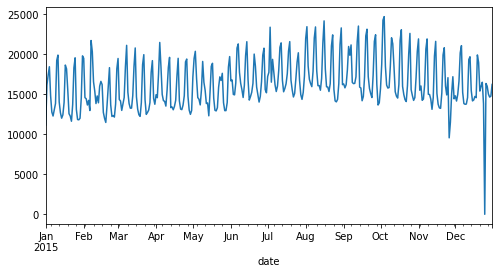

In [11]:
ts_nyc.plot(figsize=(8, 4))

In [12]:
# uma breve análise da time series
# vamos utilizar a Transformada de Fourier (FFT) para encontrar um periodo dominante
fft_values = np.fft.fft(ts_nyc)
fft_frequencies = np.fft.fftfreq(len(fft_values))
fft_values_abs = np.abs(fft_values)
dominant_frequency = np.abs(fft_frequencies[np.argmax(fft_values_abs[1:])])
period = 1 / dominant_frequency

print(f'O período dominante é: {period}')

O período dominante é: 7.156862745098039


<AxesSubplot:>

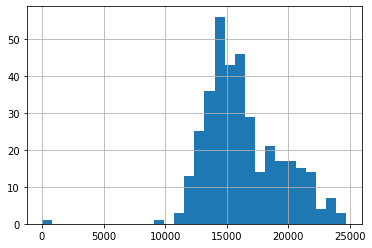

In [13]:
ts_nyc.hist(bins=30)

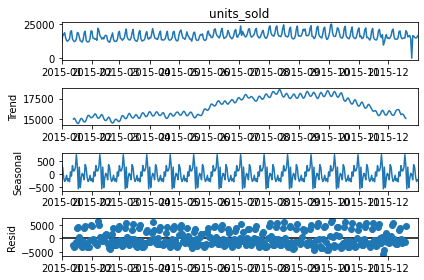

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_nyc, model='additive', period=24)
result.plot()
plt.show()

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

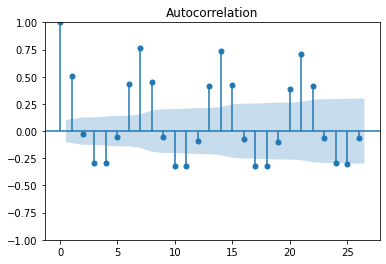

In [16]:
plt = plot_acf(ts_nyc)

C:\Users\Andre\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


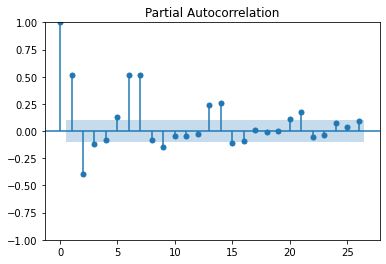

In [17]:
plt = plot_pacf(ts_nyc)

In [18]:
#heterocedastidade
from src.heteroskedasticity import Heteroskedasticity
test_results = Heteroskedasticity.run_all_tests(ts_nyc)
test_results

{'White': 0.019325615398947303,
 'Breusch-Pagan': 0.02597505266373341,
 'Goldfeld-Quandt': 0.014634434919319254}

In [19]:
# Os testes não demonstraram heterocedastidade

In [20]:
# Aplicando o ARIMA na TS
from sklearn.model_selection import train_test_split
import pmdarima as pm
from src.error import MASE

C:\Users\Andre\anaconda3\lib\site-packages\pmdarima\__init__.py:108: UserWarning: pmdarima support for 32-bit systems is ending with Python 3.10.Your system is not guaranteed to work going forward
  "pmdarima support for 32-bit systems is ending with Python 3.10."


In [21]:
train, test = train_test_split(ts_nyc, shuffle=False, test_size=30)

In [22]:
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=6261.497, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5952.142, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6124.884, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6259.503, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=6254.972, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=5890.815, Time=0.78 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=5840.655, Time=0.67 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=6124.941, Time=0.20 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=5847.853, Time=1.35 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=6061.750, Time=0.43 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=5857.777, Time=1.31 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5868.268, Time=0.52 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=5

In [23]:
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)

In [24]:
MASE(train, test, forecast)

0.7228335382844611

In [25]:
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]

<AxesSubplot:title={'center':'forecast_arima'}, xlabel='date'>

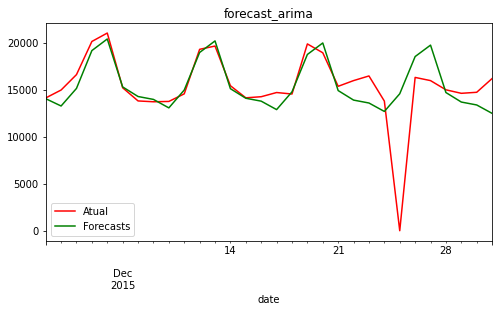

In [26]:
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (8,4))
forecasts.plot(legend=True, color = 'green')
#after_train.plot(legend=True,color = 'blue')

<AxesSubplot:title={'center':'NYC_series + forecast_arima'}, xlabel='date'>

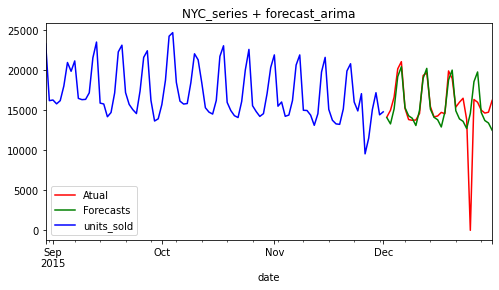

In [27]:
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'NYC_series + forecast_arima',figsize = (8,4))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')

In [28]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  335
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -2915.328
Date:                             Sun, 08 Sep 2024   AIC                           5840.655
Time:                                     16:03:24   BIC                           5859.711
Sample:                                 01-01-2015   HQIC                          5848.253
                                      - 12-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.2436      2.714     -0.827      0.408      -7.562       3.075
ar.L1         -0.2979      

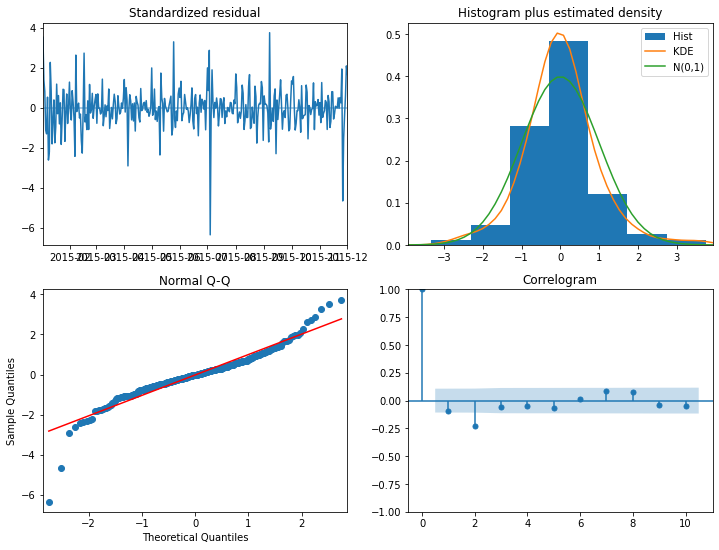

In [29]:
plot = model.plot_diagnostics(figsize = (12,9))

In [30]:
# ARIMA para a região de Boston

In [31]:
bos['date'] = pd.to_datetime(bos['date'], format='%Y-%m-%d')
bos = bos.groupby('date')['units_sold'].sum()
ts_bos = pd.Series(bos)

<AxesSubplot:xlabel='date'>

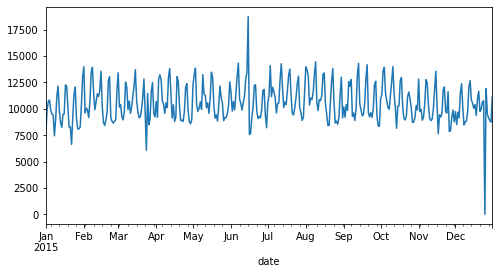

In [32]:
bos.plot(figsize=(8, 4))

<AxesSubplot:>

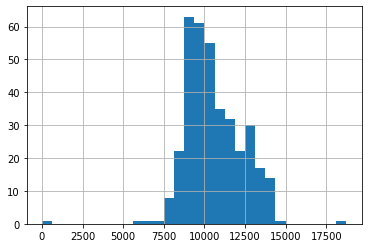

In [33]:
ts_bos.hist(bins=30)

Figure(432x288)


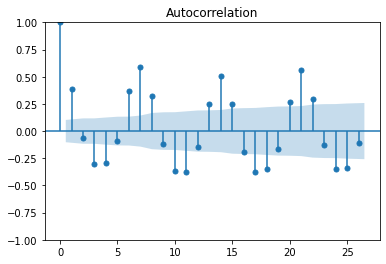

In [34]:
print(plot_acf(ts_bos))

Figure(432x288)


C:\Users\Andre\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


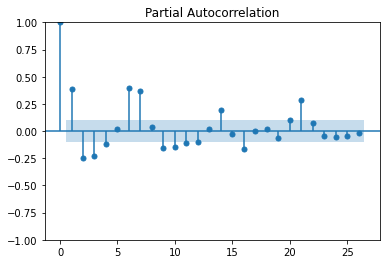

In [35]:
print(plot_pacf(ts_bos))

In [36]:
fft_values = np.fft.fft(ts_bos)
fft_frequencies = np.fft.fftfreq(len(fft_values))
fft_values_abs = np.abs(fft_values)
dominant_frequency = np.abs(fft_frequencies[np.argmax(fft_values_abs[1:])])
period = 1 / dominant_frequency

print(f'O período dominante é: {period}')

O período dominante é: 7.156862745098039


C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


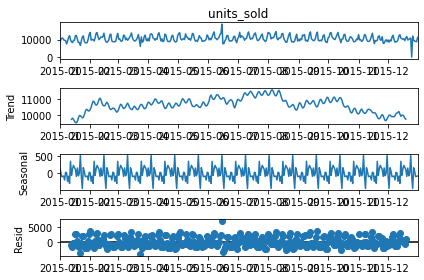

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_bos, model='additive', period=24)
result.plot()
plt.show()

In [38]:
#heterocedastidade
from src.heteroskedasticity import Heteroskedasticity
test_results = Heteroskedasticity.run_all_tests(ts_bos)
test_results

{'White': 0.6662516090794393,
 'Breusch-Pagan': 0.5877705108864643,
 'Goldfeld-Quandt': 0.777628739193761}

In [39]:
# Os testes não demonstraram heterocedastidade

In [40]:
train, test = train_test_split(ts_bos, shuffle=False, test_size=30)

In [41]:
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=5741.578, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5944.189, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5796.183, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5800.229, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=7173.455, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=5741.240, Time=0.64 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=5771.942, Time=0.22 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=5752.797, Time=0.77 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=5715.530, Time=0.72 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=5734.001, Time=0.67 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=5770.803, Time=0.45 sec
 ARIMA(3,0,2)(1,0,0)[7] intercept   : AIC=5717.584, Time=0.66 sec
 ARIMA(2,0,3)(1,0,0)[7] intercept   : AIC=5

In [42]:
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)

In [43]:
MASE(train, test, forecast)

1.0637419319485244

In [44]:
# O modelo apresentou erro ao rodar por isso a necessidade de incluir o error_action="ignore"

In [45]:
data_corte = '2015-08-30'
before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]

<AxesSubplot:title={'center':'forecast_arima'}, xlabel='date'>

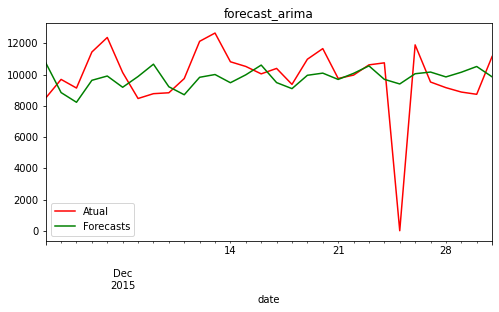

In [46]:
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (8,4))
forecasts.plot(legend=True, color = 'green')
#after_train.plot(legend=True,color = 'blue')

<AxesSubplot:title={'center':'forecast_arima'}, xlabel='date'>

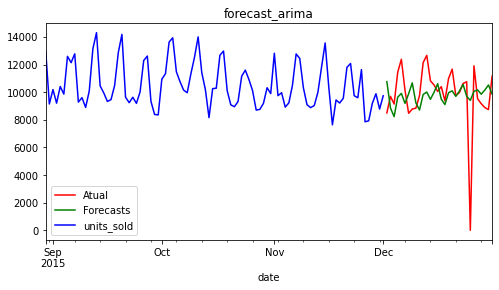

In [47]:
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (8,4))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')

In [48]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  335
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 7)   Log Likelihood               -2850.765
Date:                            Sun, 08 Sep 2024   AIC                           5715.530
Time:                                    16:03:40   BIC                           5742.229
Sample:                                01-01-2015   HQIC                          5726.174
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7110.8905   1390.045      5.116      0.000    4386.452    9835.329
ar.L1         -1.4207      0.049   

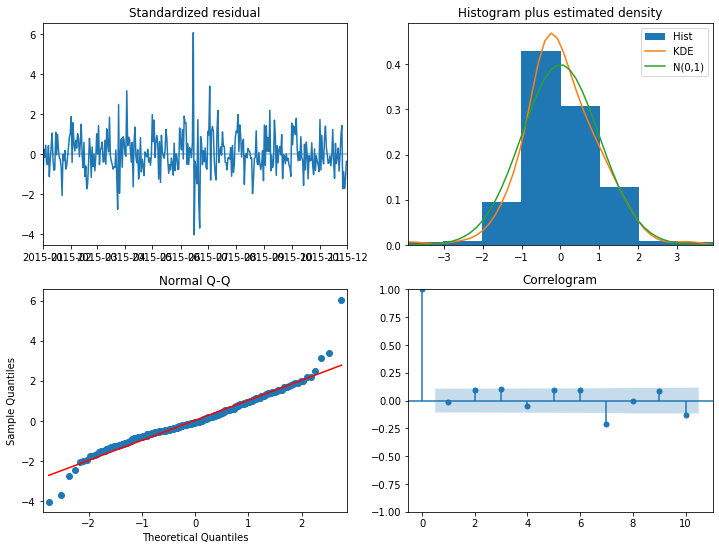

In [49]:
plot = model.plot_diagnostics(figsize = (12, 9))

In [50]:
# ARIMA para a região de Philadelfia

<AxesSubplot:xlabel='date'>

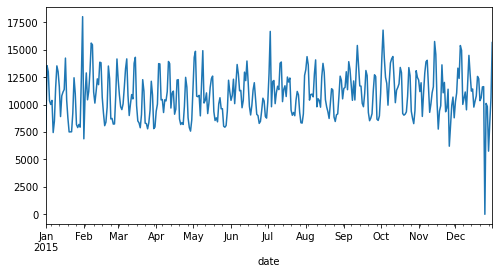

In [51]:
phi['date'] = pd.to_datetime(phi['date'], format='%Y-%m-%d')
phi = phi.groupby('date')['units_sold'].sum()
ts_phi = pd.Series(phi)
phi.plot(figsize=(8, 4))

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


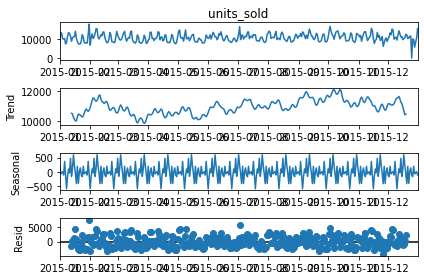

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_phi, model='additive', period=24)
result.plot()
plt.show()

<AxesSubplot:>

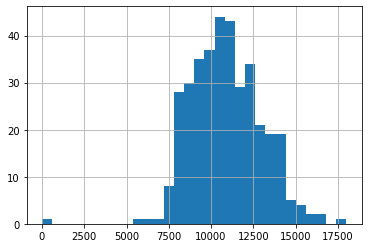

In [53]:
ts_phi.hist(bins=30)

In [54]:
#heterocedastidade
from src.heteroskedasticity import Heteroskedasticity
test_results = Heteroskedasticity.run_all_tests(ts_phi)
test_results

{'White': 0.003582067982582692,
 'Breusch-Pagan': 0.5874124528599105,
 'Goldfeld-Quandt': 0.6526206219549481}

In [55]:
# aqui os testes estão contraditórios

In [56]:
train, test = train_test_split(ts_phi, shuffle=False, test_size=30)

In [57]:
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=5869.114, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6047.438, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5910.428, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5902.142, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=7191.176, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=5902.025, Time=0.28 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=5886.842, Time=1.15 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=5870.778, Time=1.41 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=5929.535, Time=0.12 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=5891.876, Time=0.56 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=5877.797, Time=2.40 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=5860.967, Time=1.81 sec
 ARIMA(1,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(2,0,1)(2,0,2)[7] intercept   : AIC=i

In [58]:
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)

In [59]:
MASE(train, test, forecast)

1.2151234516086258

<AxesSubplot:title={'center':'forecast_arima'}, xlabel='date'>

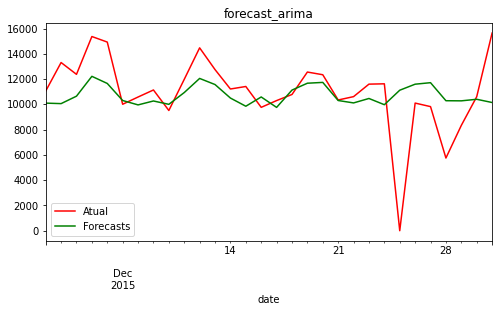

In [60]:
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (8,4))
forecasts.plot(legend=True, color = 'green')
#after_train.plot(legend=True,color = 'blue')

In [61]:
print(model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  335
Model:             SARIMAX(3, 0, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -2908.225
Date:                                Sun, 08 Sep 2024   AIC                           5840.450
Time:                                        16:04:26   BIC                           5886.219
Sample:                                    01-01-2015   HQIC                          5858.697
                                         - 12-01-2015                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7290.5341   1.12e+04      0.653      0.514   -1.46e+04    2.92e+04
ar.

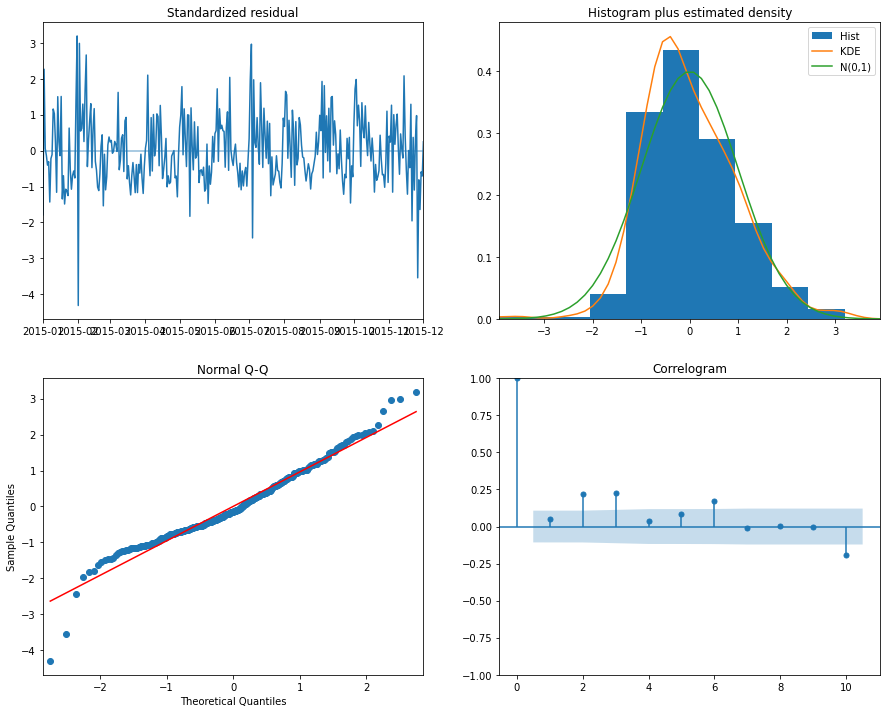

In [62]:
plot = model.plot_diagnostics(figsize = (15,12))

In [63]:
# aplicando o boxcox na série
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [64]:
ts_phi_bc, best_lambda = boxcox(ts_phi)
ts_phi_bc = pd.Series(ts_phi_bc)
ts_phi_bc = ts_phi_bc.astype(np.float32)


<AxesSubplot:>

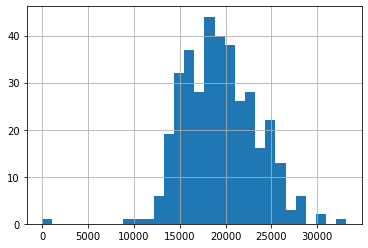

In [65]:
pd.Series(ts_phi_bc).hist(bins=30)

In [66]:
train, test = train_test_split(ts_phi_bc, shuffle=False, test_size=30)

In [67]:
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=6302.029, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6479.635, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=6343.236, Time=0.50 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=6335.127, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=7579.720, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=6335.160, Time=0.23 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=6318.624, Time=1.14 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=6298.800, Time=1.83 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=6310.688, Time=2.70 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=6293.134, Time=1.79 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=6296.584, Time=1.36 sec
 ARIMA(1,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(2,0,1)(2,0,2)[7] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(3,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(2,0,3)(2,0,2)[7] intercept   : AIC=6268.3

In [68]:
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)

In [69]:
MASE(train, test, forecast)

1.2181166025120205

<AxesSubplot:title={'center':'forecast_arima'}>

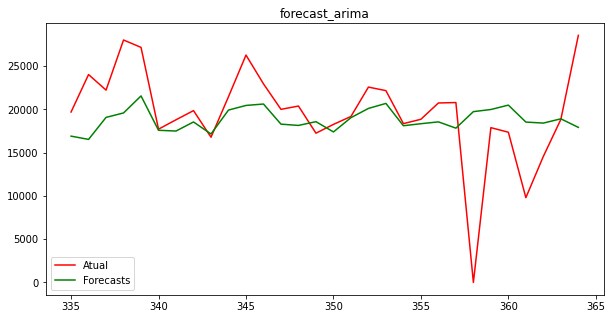

In [70]:

test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
#train.plot(legend=True,color = 'blue')

In [71]:
print(model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  335
Model:             SARIMAX(2, 0, 4)x(2, 0, [1, 2], 7)   Log Likelihood               -3113.549
Date:                                Sun, 08 Sep 2024   AIC                           6251.098
Time:                                        16:05:17   BIC                           6296.867
Sample:                                             0   HQIC                          6269.345
                                                - 335                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.385e+04   7917.822      1.749      0.080   -1669.372    2.94e+04
ar.

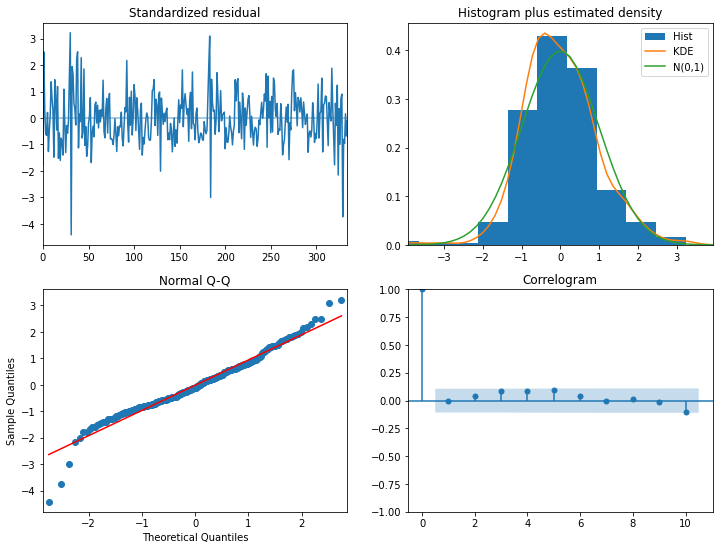

In [72]:
plot = model.plot_diagnostics(figsize = (12,9))

In [73]:
# ARIMA por loja NCY

In [74]:
nyc = pd.read_csv('nyc_2015.csv', dtype=dtypes)

In [75]:
nyc['date'] = pd.to_datetime(nyc['date'], format='%Y-%m-%d')

In [76]:
nyc1 = nyc[nyc['store_code'] == 'NYC_1']
nyc2 = nyc[nyc['store_code'] == 'NYC_2']
nyc3 = nyc[nyc['store_code'] == 'NYC_3']
nyc4 = nyc[nyc['store_code'] == 'NYC_4']

In [77]:
nyc1 = nyc1.groupby('date')['units_sold'].sum()
nyc2 = nyc2.groupby('date')['units_sold'].sum()
nyc3 = nyc3.groupby('date')['units_sold'].sum()
nyc4 = nyc4.groupby('date')['units_sold'].sum()

In [78]:
ts_nyc1 = pd.Series(nyc1)
ts_nyc2 = pd.Series(nyc2)
ts_nyc3 = pd.Series(nyc3)
ts_nyc4 = pd.Series(nyc4)

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


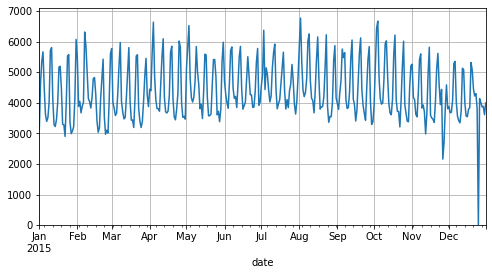

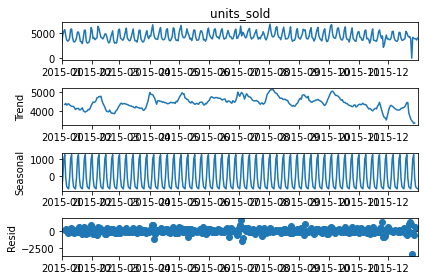

In [79]:
# NYC1
ts_nyc1.plot(figsize=(8, 4))
pd.Series(ts_nyc1).hist(bins=30)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_nyc1, model='additive', period=7)
result.plot()
plt.show()


teste de heterocedastidade : {'White': 0.23715027778881384, 'Breusch-Pagan': 0.7367964000373896, 'Goldfeld-Quandt': 0.8647027259544919}
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=5004.917, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5477.077, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5178.418, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5342.676, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5475.081, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=5181.965, Time=1.08 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=5210.885, Time=0.37 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=5160.017, Time=1.46 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Ti

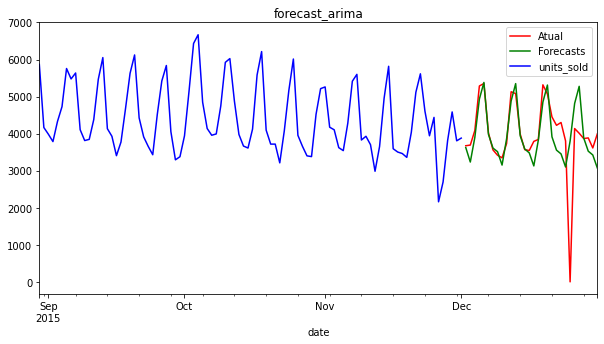

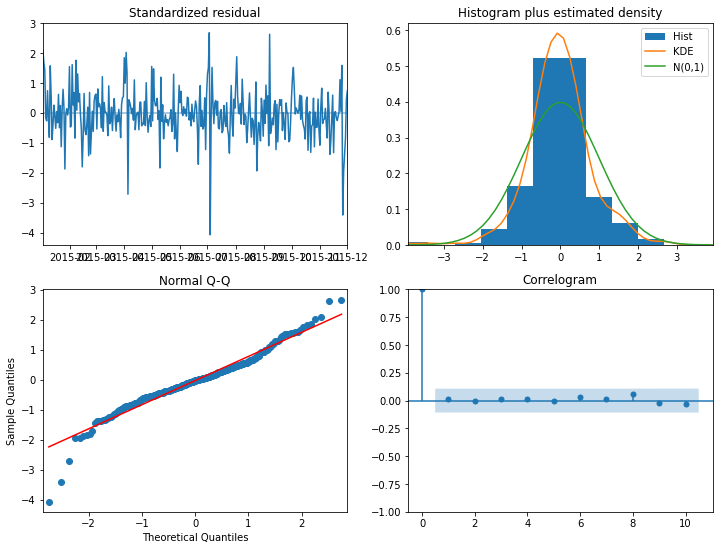

In [80]:
#heterocedastidade
test_results = Heteroskedasticity.run_all_tests(ts_nyc1)
print('teste de heterocedastidade :', test_results)
# ARIMA
train, test = train_test_split(ts_nyc1, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
print('MASE: ', MASE(train, test, forecast))
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
#before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]
# IMPRIMINDO O GRÁFICO
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')
# MODEL SUMMARY
print(model.summary())
plot = model.plot_diagnostics(figsize = (12,9))

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


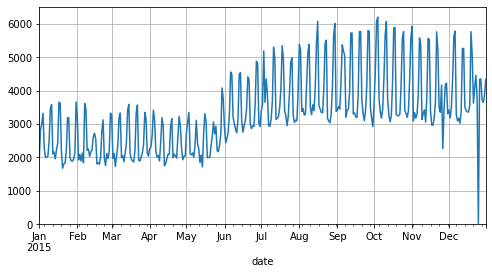

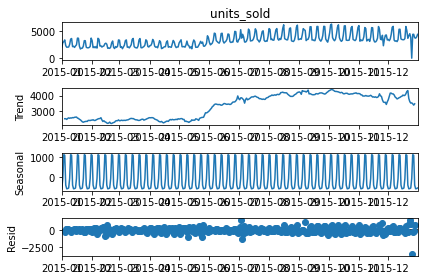

In [81]:
# NYC2
ts_nyc2.plot(figsize=(8, 4))
pd.Series(ts_nyc2).hist(bins=30)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_nyc2, model='additive', period=7)
result.plot()
plt.show()

teste de heterocedastidade : {'White': 1.1979487810230081e-05, 'Breusch-Pagan': 2.174633849398298e-06, 'Goldfeld-Quandt': 8.071218752737676e-09}
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5464.560, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5052.987, Time=0.53 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5235.434, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5462.569, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5462.248, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=4927.789, Time=0.72 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=5309.450, Time=0.18 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=4979.233, Time=1.08 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=4926.121, Time=1.21 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=5212.807, Time=0.41 sec
 ARIMA(1,1,0)(2,0,2)[7] interc

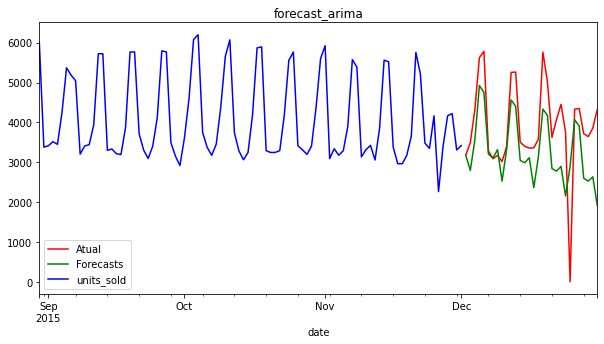

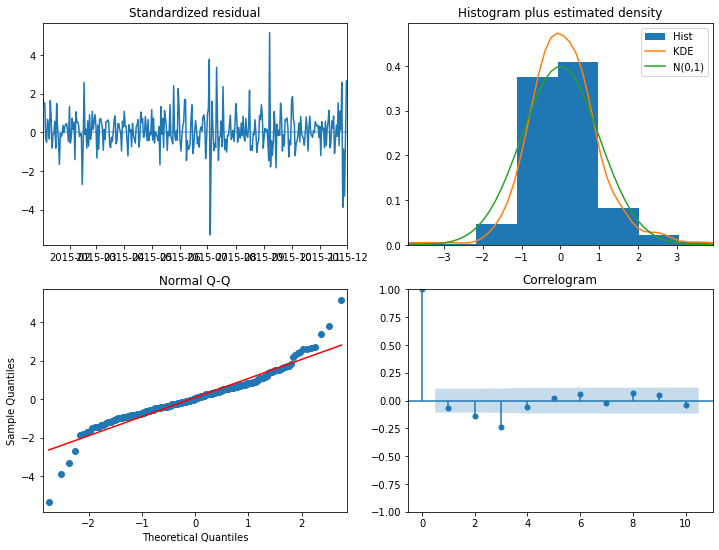

In [82]:

#heterocedastidade
test_results = Heteroskedasticity.run_all_tests(ts_nyc2)
print('teste de heterocedastidade :', test_results)
# ARIMA
train, test = train_test_split(ts_nyc2, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
print('MASE: ', MASE(train, test, forecast))
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
#before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]
# IMPRIMINDO O GRÁFICO
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')
# MODEL SUMMARY
print(model.summary())
plot = model.plot_diagnostics(figsize = (12,9))

In [83]:
# aplicando o boxcox na série
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [84]:
ts_nyc2_bc, best_lambda = boxcox(ts_nyc2)
ts_nyc2_bc = pd.Series(ts_nyc2_bc)
ts_nyc2_bc = ts_nyc2_bc.astype(np.float32)

In [85]:
train, test = train_test_split(ts_nyc2_bc, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=2590.771, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3205.836, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2806.087, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2984.693, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3203.847, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=2846.910, Time=0.52 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=2689.103, Time=0.63 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=2592.089, Time=1.23 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=2592.206, Time=1.32 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=2902.945, Time=0.21 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=2798.541, Time=1.04 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=2623.291, Time=1.31 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=2593.626, Time=1.86 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=2589.668, Time=0.64 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept

In [86]:
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
MASE(train, test, forecast)

1.369850109406335

<AxesSubplot:title={'center':'forecast_arima'}>

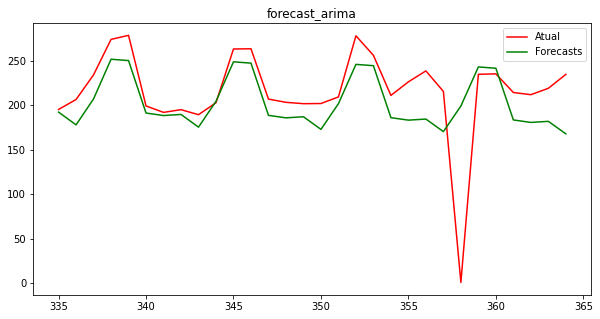

In [87]:
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
#train.plot(legend=True,color = 'blue')

In [88]:
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  335
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1287.969
Date:                           Sun, 08 Sep 2024   AIC                           2583.937
Time:                                   16:06:47   BIC                           2599.182
Sample:                                        0   HQIC                          2590.015
                                           - 335                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8497      0.024    -36.090      0.000      -0.896      -0.804
ar.S.L7        0.9952      0.005    208.667

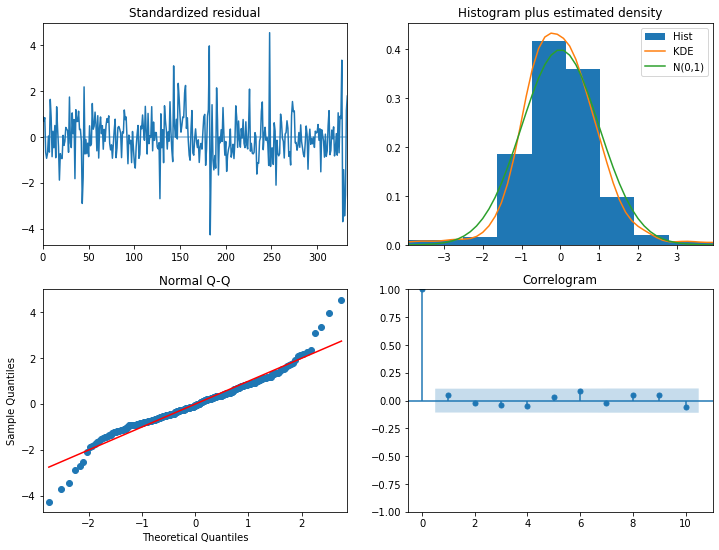

In [89]:
plot = model.plot_diagnostics(figsize = (12,9))

In [90]:
# NYC3

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


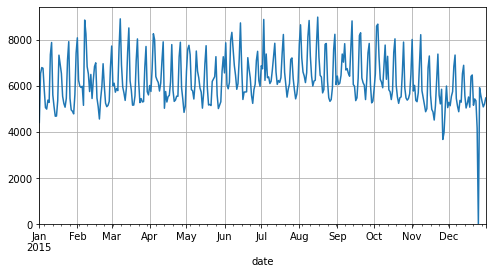

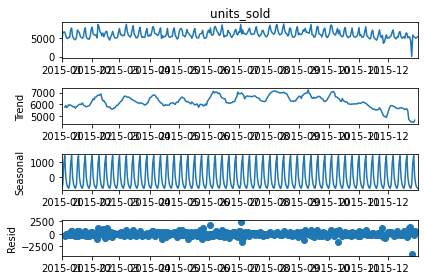

In [91]:
ts_nyc3.plot(figsize=(8, 4))
ts_nyc3.hist(bins=30)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_nyc3, model='additive', period=7)
result.plot()
plt.show()

teste de heterocedastidade : {'White': 0.07874229253254526, 'Breusch-Pagan': 0.2742884191077859, 'Goldfeld-Quandt': 0.6739655508214883}
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5579.974, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5375.300, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5444.284, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5577.978, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5581.727, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=5330.316, Time=0.60 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=5326.943, Time=1.05 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=5349.516, Time=1.00 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=5325.66

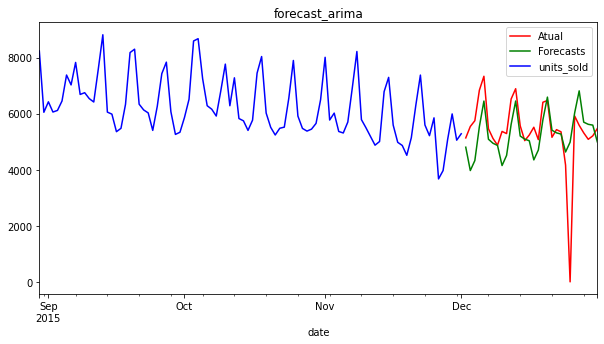

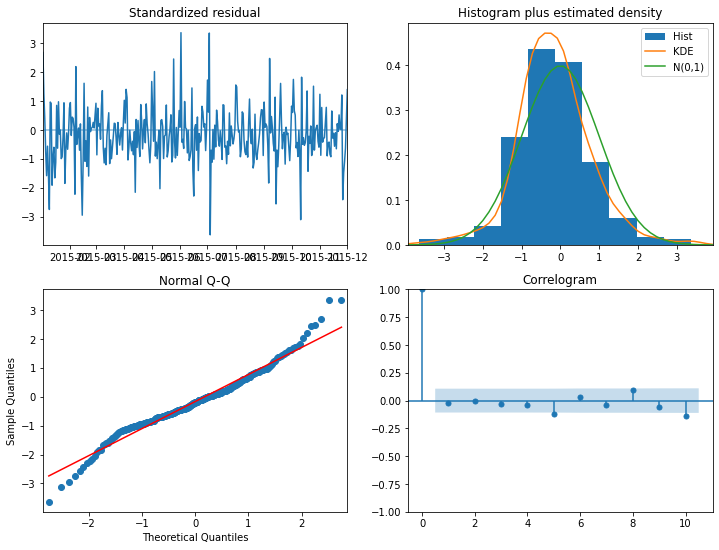

In [92]:

#heterocedastidade
test_results = Heteroskedasticity.run_all_tests(ts_nyc3)
print('teste de heterocedastidade :', test_results)
# ARIMA
train, test = train_test_split(ts_nyc3, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
print('MASE: ', MASE(train, test, forecast))
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
#before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]
# IMPRIMINDO O GRÁFICO
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')
# MODEL SUMMARY
print(model.summary())
plot = model.plot_diagnostics(figsize = (12,9))

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


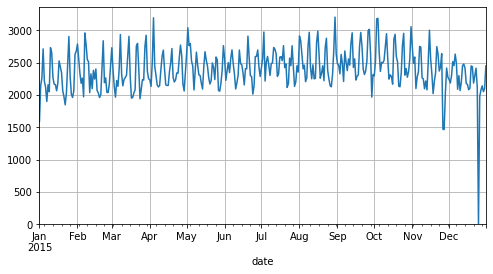

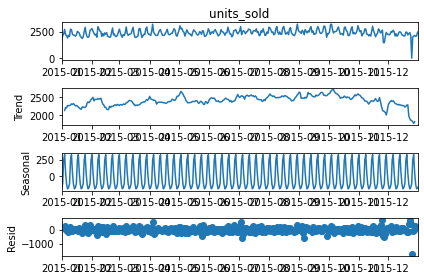

In [93]:
# NYC4
ts_nyc4.plot(figsize=(8, 4))
pd.Series(ts_nyc4).hist(bins=30)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_nyc4, model='additive', period=7)
result.plot()
plt.show()

teste de heterocedastidade : {'White': 0.0070150997261376755, 'Breusch-Pagan': 0.08476328067755778, 'Goldfeld-Quandt': 0.009085987043518363}
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4752.926, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4659.097, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4644.113, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4750.940, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=4754.456, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=4601.606, Time=0.95 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=4689.724, Time=0.35 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=4566.672, Time=0.96 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=in

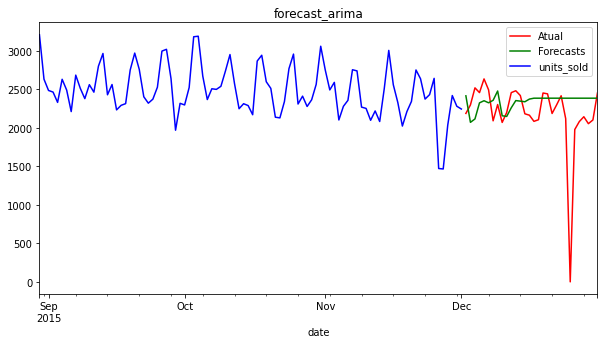

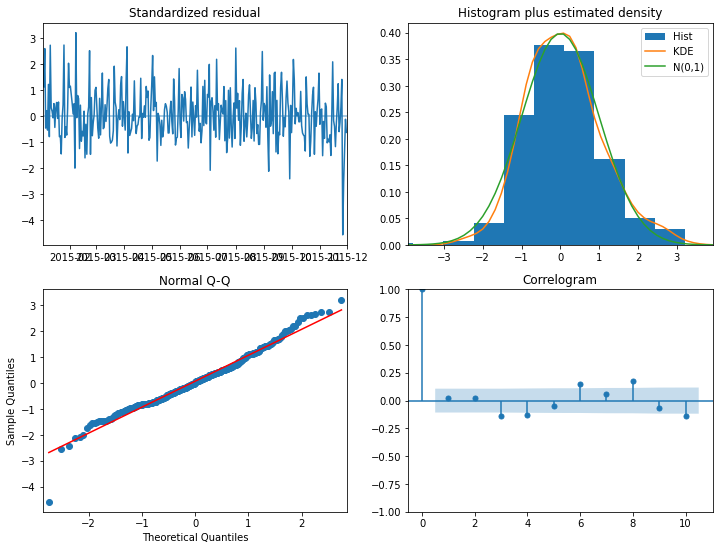

In [94]:
#heterocedastidade
test_results = Heteroskedasticity.run_all_tests(ts_nyc4)
print('teste de heterocedastidade :', test_results)
# ARIMA
train, test = train_test_split(ts_nyc4, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
print('MASE: ', MASE(train, test, forecast))
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
#before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]
# IMPRIMINDO O GRÁFICO
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')
# MODEL SUMMARY
print(model.summary())
plot = model.plot_diagnostics(figsize = (12,9))

In [98]:
# ARIMA BOSTON 
bos = pd.read_csv('bos_2015.csv', dtype=dtypes)

In [99]:
bos['date'] = pd.to_datetime(bos['date'], format='%Y-%m-%d')

In [100]:
bos1 = bos[bos['store_code'] == 'BOS_1']
bos2 = bos[bos['store_code'] == 'BOS_2']
bos3 = bos[bos['store_code'] == 'BOS_3']

In [101]:
bos1 = bos1.groupby('date')['units_sold'].sum()
bos2 = bos2.groupby('date')['units_sold'].sum()
bos3 = bos3.groupby('date')['units_sold'].sum()

In [102]:
ts_bos1 = pd.Series(bos1)
ts_bos2 = pd.Series(bos2)
ts_bos3 = pd.Series(bos3)

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


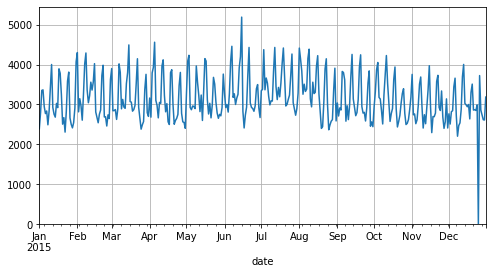

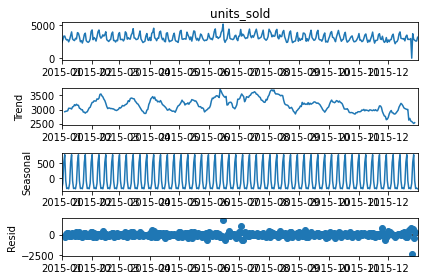

In [103]:
# ARIMA BOS1
ts_bos1.plot(figsize=(8, 4))
pd.Series(ts_bos1).hist(bins=30)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_bos1, model='additive', period=7)
result.plot()
plt.show()

teste de heterocedastidade : {'White': 0.8580881249621067, 'Breusch-Pagan': 0.654648914918285, 'Goldfeld-Quandt': 0.8033888935634141}
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=4923.528, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5181.162, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4991.380, Time=0.56 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5015.023, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6365.492, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=4957.005, Time=0.66 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=4892.203, Time=0.87 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=4997.735, Time=0.34 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=4919.551, Time=1.51 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=4903.193, Time=0.72 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=4965.379, Time=0.68 sec
 ARIMA(3,0,2)(1,0,0)[7] intercept   

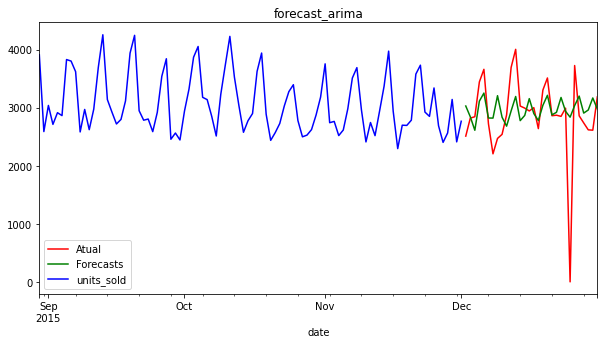

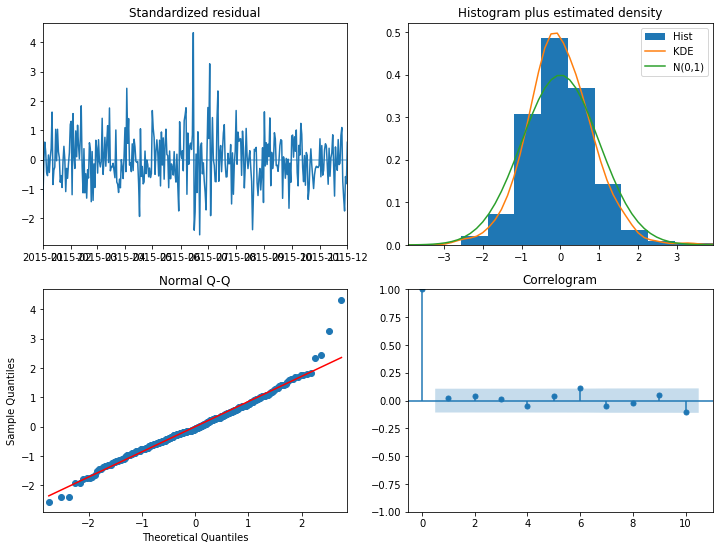

In [104]:
#heterocedastidade
test_results = Heteroskedasticity.run_all_tests(ts_bos1)
print('teste de heterocedastidade :', test_results)
# ARIMA
train, test = train_test_split(ts_bos1, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
print('MASE: ', MASE(train, test, forecast))
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
#before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]
# IMPRIMINDO O GRÁFICO
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')
# MODEL SUMMARY
print(model.summary())
plot = model.plot_diagnostics(figsize = (12,9))

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


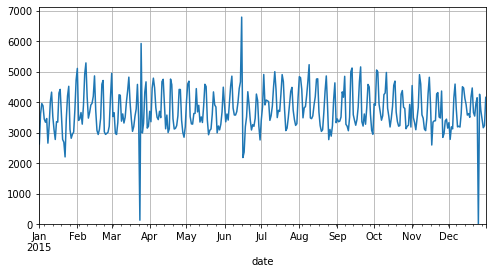

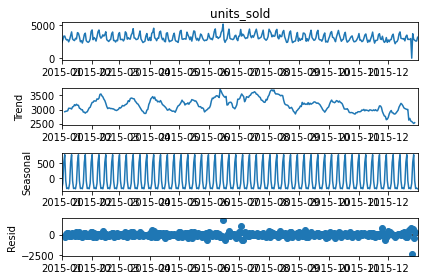

In [105]:
#ARIMA BOS2
ts_bos2.plot(figsize=(8, 4))
pd.Series(ts_bos2).hist(bins=30)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_bos1, model='additive', period=7)
result.plot()
plt.show()

teste de heterocedastidade : {'White': 0.8103390645139861, 'Breusch-Pagan': 0.7788286886281119, 'Goldfeld-Quandt': 0.10581782510566518}
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5325.901, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5221.382, Time=0.55 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5230.526, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6477.350, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=5290.975, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=5220.121, Time=7.48 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=5324.710, Time=2.17 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=5235.293, Time=9.76 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=5277.442

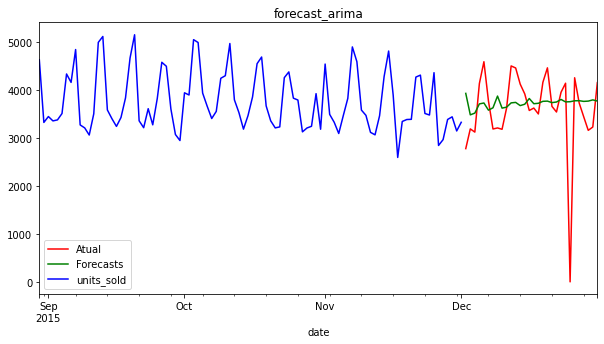

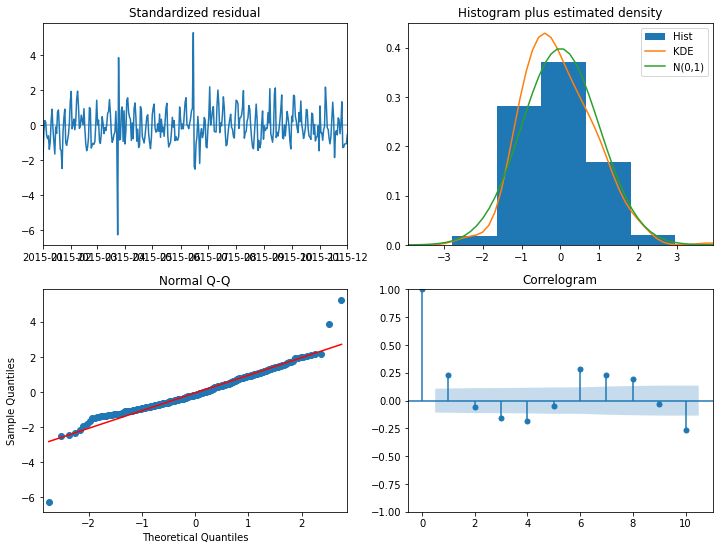

In [106]:
#heterocedastidade
test_results = Heteroskedasticity.run_all_tests(ts_bos2)
print('teste de heterocedastidade :', test_results)
# ARIMA
train, test = train_test_split(ts_bos2, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
print('MASE: ', MASE(train, test, forecast))
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
#before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]
# IMPRIMINDO O GRÁFICO
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')
# MODEL SUMMARY
print(model.summary())
plot = model.plot_diagnostics(figsize = (12,9))

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


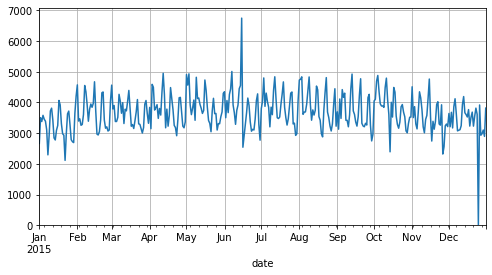

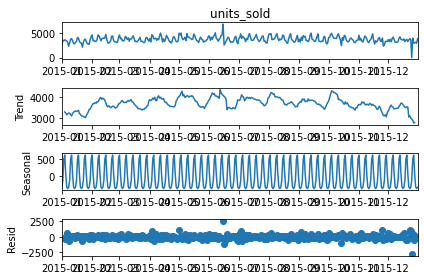

In [107]:
# ARIMA BOS3
ts_bos3.plot(figsize=(8, 4))
pd.Series(ts_bos3).hist(bins=30)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_bos3, model='additive', period=7)
result.plot()
plt.show()

teste de heterocedastidade : {'White': 0.49957436194221083, 'Breusch-Pagan': 0.408714970125856, 'Goldfeld-Quandt': 0.8928463968178408}
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5234.886, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5162.444, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5132.261, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5232.896, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=5193.598, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=5112.541, Time=1.02 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=5200.003, Time=0.29 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=5083.170, Time=1.00 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=5101.407, Time=0.40 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf

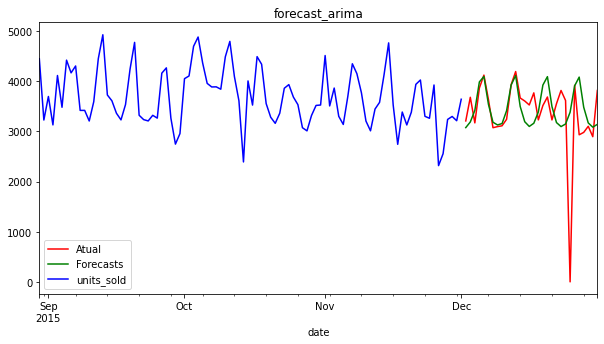

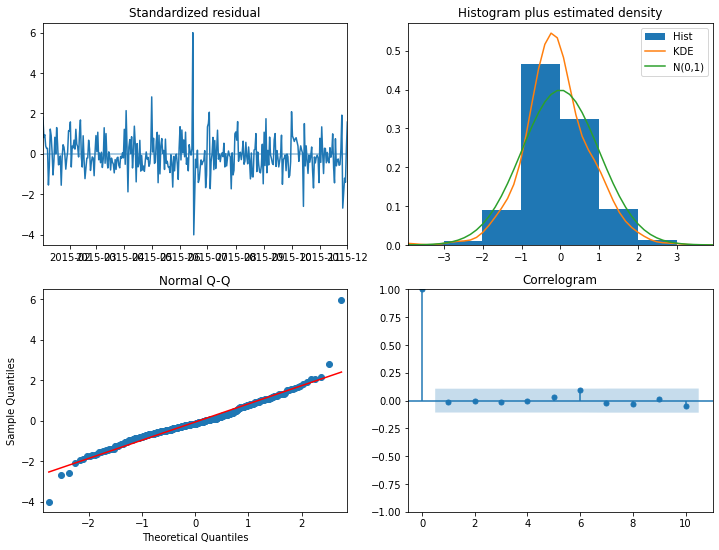

In [108]:
#heterocedastidade
test_results = Heteroskedasticity.run_all_tests(ts_bos3)
print('teste de heterocedastidade :', test_results)
# ARIMA
train, test = train_test_split(ts_bos3, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
print('MASE: ', MASE(train, test, forecast))
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
#before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]
# IMPRIMINDO O GRÁFICO
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')
# MODEL SUMMARY
print(model.summary())
plot = model.plot_diagnostics(figsize = (12,9))

In [109]:
# ARIMA PHI
phi = pd.read_csv('phi_2015.csv', dtype=dtypes)

In [110]:
phi['date'] = pd.to_datetime(phi['date'], format='%Y-%m-%d')

In [111]:
phi1 = phi[phi['store_code'] == 'PHI_1']
phi2 = phi[phi['store_code'] == 'PHI_2']
phi3 = phi[phi['store_code'] == 'PHI_3']

In [112]:
phi1 = phi1.groupby('date')['units_sold'].sum()
phi2 = phi2.groupby('date')['units_sold'].sum()
phi3 = phi3.groupby('date')['units_sold'].sum()

In [113]:
ts_phi1 = pd.Series(phi1)
ts_phi2 = pd.Series(phi2)
ts_phi3 = pd.Series(phi3)

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


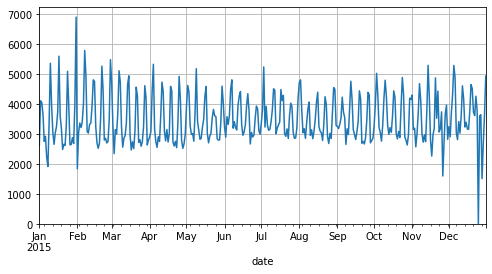

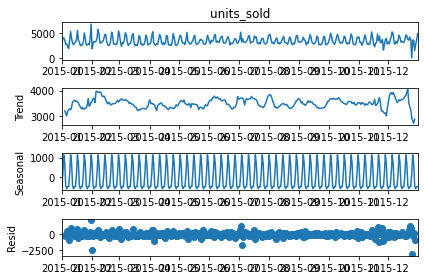

In [114]:
# ARIMA PHI1
ts_phi1.plot(figsize=(8, 4))
pd.Series(ts_phi1).hist(bins=30)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_phi1, model='additive', period=7)
result.plot()
plt.show()

teste de heterocedastidade : {'White': 7.865463769505655e-05, 'Breusch-Pagan': 0.18434222463412867, 'Goldfeld-Quandt': 0.10815073317681685}
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5408.144, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5216.325, Time=0.64 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5229.836, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6433.485, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=5358.124, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=5206.836, Time=6.17 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=5203.461, Time=1.34 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=5234.219, Time=0.61 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=5189.140, Time=1.00 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=5197.627, Time=0.38 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept  

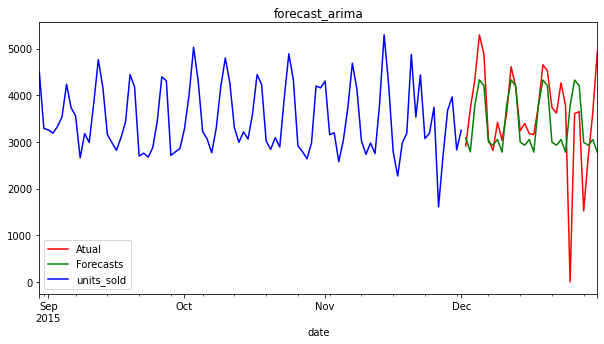

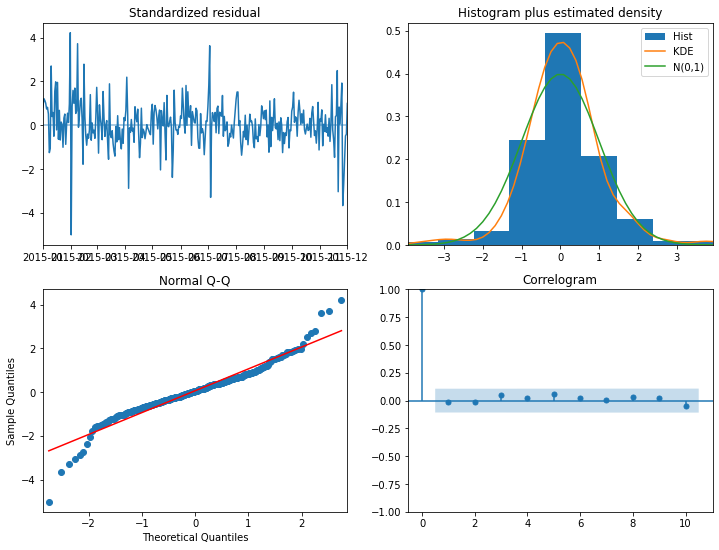

In [115]:
#heterocedastidade
test_results = Heteroskedasticity.run_all_tests(ts_phi1)
print('teste de heterocedastidade :', test_results)
# ARIMA
train, test = train_test_split(ts_phi1, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
print('MASE: ', MASE(train, test, forecast))
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
#before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]
# IMPRIMINDO O GRÁFICO
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')
# MODEL SUMMARY
print(model.summary())
plot = model.plot_diagnostics(figsize = (12,9))

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


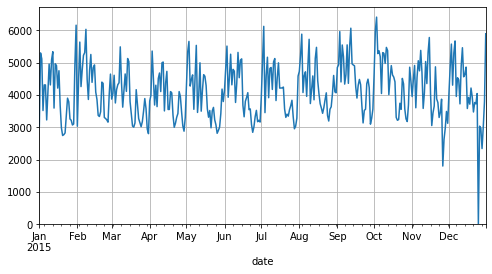

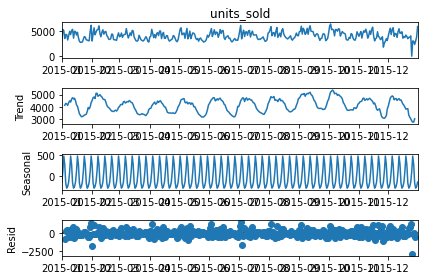

In [116]:
# ARIMA PHI2
ts_phi2.plot(figsize=(8, 4))
pd.Series(ts_phi2).hist(bins=30)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_phi2, model='additive', period=7)
result.plot()
plt.show()

teste de heterocedastidade : {'White': 0.004768459944034288, 'Breusch-Pagan': 0.06854043869681414, 'Goldfeld-Quandt': 0.10165021010029536}
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=5299.915, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5438.393, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5320.000, Time=0.35 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5313.793, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6544.478, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=5292.314, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=5292.790, Time=0.11 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=5294.313, Time=0.57 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=5320.700, Time=1.49 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=5308.134, Time=0.16 sec
 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=5321.510, Time=0.44 sec
 ARIMA(3,0,2)(0,0,1)[7] interce

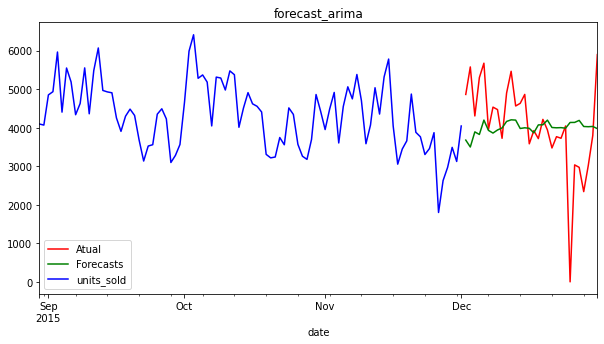

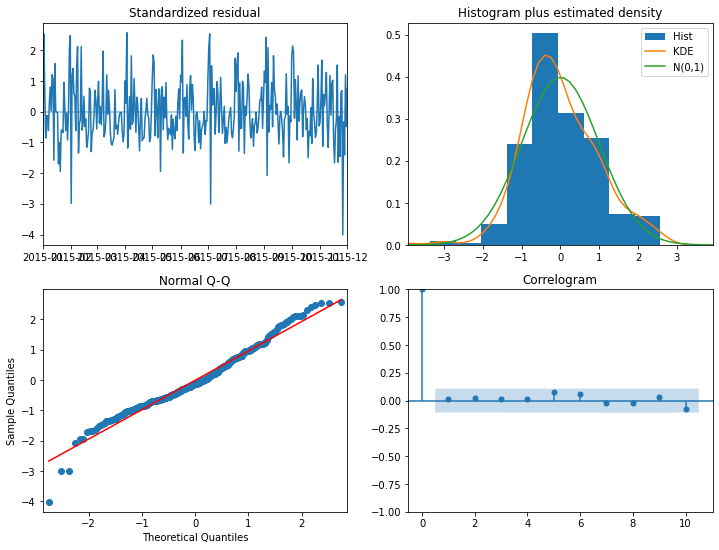

In [117]:
#heterocedastidade
test_results = Heteroskedasticity.run_all_tests(ts_phi2)
print('teste de heterocedastidade :', test_results)
# ARIMA
train, test = train_test_split(ts_phi2, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
print('MASE: ', MASE(train, test, forecast))
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
#before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]
# IMPRIMINDO O GRÁFICO
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')
# MODEL SUMMARY
print(model.summary())
plot = model.plot_diagnostics(figsize = (12,9))

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


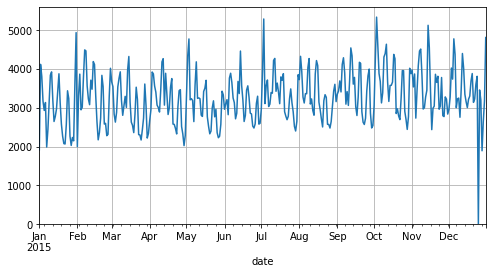

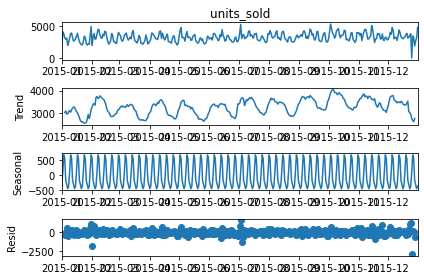

In [118]:
#ARIMA PHI3
ts_phi3.plot(figsize=(8, 4))
pd.Series(ts_phi3).hist(bins=30)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_phi3, model='additive', period=7)
result.plot()
plt.show()

teste de heterocedastidade : {'White': 0.016706449015289216, 'Breusch-Pagan': 0.42110355327915594, 'Goldfeld-Quandt': 0.33100245492216973}
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5240.026, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5172.016, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5191.933, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5238.036, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5242.226, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=5131.225, Time=0.38 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=5064.190, Time=1.17 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=5056.164, Time=0.54 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=5207.176, Time=0.18 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=5059.981, Time=0.92 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=5180.907, Time=0.41 sec
 ARIMA(1,1,0)(2,0,2)[7] interce

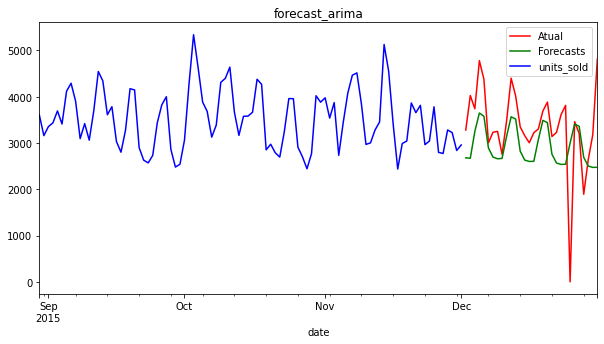

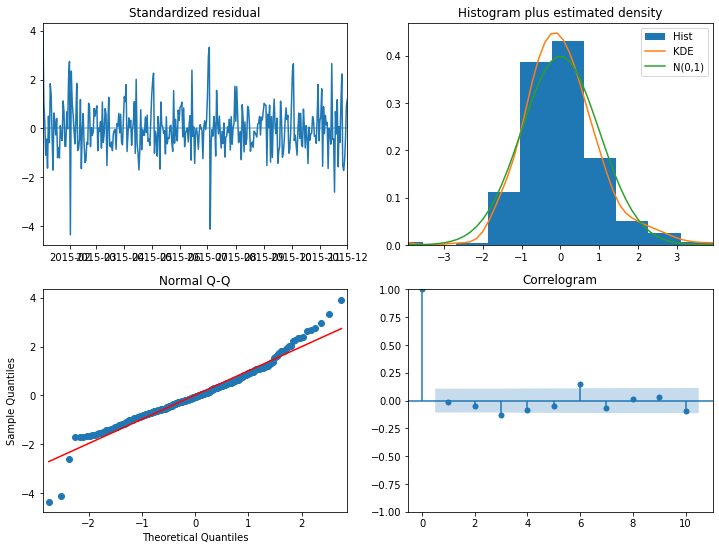

In [119]:
#heterocedastidade
test_results = Heteroskedasticity.run_all_tests(ts_phi3)
print('teste de heterocedastidade :', test_results)
# ARIMA
train, test = train_test_split(ts_phi3, shuffle=False, test_size=30)
model = pm.auto_arima(train, seasonal=True, m=7, trace=True, suppress_warnings=True, approximation=True, error_action="ignore")
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
print('MASE: ', MASE(train, test, forecast))
# diminuindo a série train para melhor visualização gráfica 
data_corte = '2015-08-30'
#before_train = train[train.index < data_corte]
after_train = train[train.index >= data_corte]
# IMPRIMINDO O GRÁFICO
test = pd.Series(test).rename('Atual')
forecasts = pd.Series(forecast, index = test.index).rename('Forecasts')
ax = pd.Series(test).plot(legend = True, color='red', title = 'forecast_arima',figsize = (10,5))
forecasts.plot(legend=True, color = 'green')
after_train.plot(legend=True,color = 'blue')
# MODEL SUMMARY
print(model.summary())
plot = model.plot_diagnostics(figsize = (12,9))